In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
batch_size,num_steps=32,35
train_iter,vocab=d2l.load_data_time_machine(batch_size,num_steps)

In [3]:
F.one_hot(torch.tensor([0,2]),len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [4]:
#小批量数据的形状是（批量大小，时间步数）
X=torch.arange(10).reshape((2,5))
F.one_hot(X.T,28).shape

torch.Size([5, 2, 28])

In [5]:
#初始化模型参数
def get_params(vocab_size,num_hiddens,device):
    num_inputs=num_outputs=vocab_size
    def normal(shape):
        return torch.randn(size=shape,device=device)*0.01
    W_xh=normal((num_inputs,num_hiddens))
    W_hh=normal((num_hiddens,num_hiddens))
    b_h=torch.zeros(num_hiddens,device=device)
    W_hq=normal((num_hiddens,num_outputs))
    b_q=torch.zeros(num_outputs,device=device)
    params=[W_xh,W_hh,b_h,W_hq,b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [6]:
#初始化第一个隐藏状态
def init_rnn_state(batch_size,num_hiddens,device):
    return (torch.zeros((batch_size,num_hiddens),device=device),)

In [7]:
def rnn(inputs,state,params):
    W_xh,W_hh,b_h,W_hq,b_q=params
    H,=state
    outputs=[]
    for X in inputs:
        H=torch.tanh(torch.mm(X,W_xh)+torch.mm(H,W_hh)+b_h)
        Y=torch.mm(H,W_hq)+b_q
        outputs.append(Y)
    return torch.cat(outputs,dim=0),(H,)

In [8]:
#创建一个类包装这些函数
class RNNModelScratch:
    def __init__(self,vocab_size,num_hiddens,device,get_params,init_state,forward_fn):
        self.vocab_size,self.num_hiddens=vocab_size,num_hiddens
        self.params=get_params(vocab_size,num_hiddens,device)
        self.init_state,self.forward_fn=init_state,forward_fn
    def __call__(self,X,state):
        X=F.one_hot(X.T,self.vocab_size).type(torch.float32)
        return self.forward_fn(X,state,self.params)
    def begin_state(self,batch_size,device):
        return self.init_state(batch_size,self.num_hiddens,device)

In [9]:
num_hiddens=512
net=RNNModelScratch(len(vocab),num_hiddens,d2l.try_gpu(),get_params,init_rnn_state,rnn)
state=net.begin_state(X.shape[0],d2l.try_gpu())
Y,new_state=net(X.to(d2l.try_gpu()),state)
Y.shape,len(new_state),new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [10]:
#定义一个预测函数来生成prefix之后的新字符
def predict_ch8(prefix,num_preds,net,vocab,device):
    state=net.begin_state(batch_size=1,device=device)
    outputs=[vocab[prefix[0]]]
    get_input=lambda:torch.tensor([outputs[-1]],device=device).reshape(1,1)
    for y in prefix[1:]:
        _,state=net(get_input(),state)
        outputs.append(vocab[y])
    for _ in range(num_preds):
        y,state=net(get_input(),state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])
predict_ch8('time traveller ',10,net,vocab,d2l.try_gpu())

'time traveller szfckrockr'

In [15]:
#梯度裁剪
def grad_clipping(net,theta):
    if isinstance(net,nn.Module):
        params=[p for p in net.parameters() if p.requires_grad]
    else:
        params=net.params
    norm=torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm>theta:
        for param in params:
            param.grad[:]*=theta/norm

In [12]:
#定义一个函数在一个迭代周期内训练函数
def train_epoch_ch8(net,train_iter,loss,updater,device,use_random_iter):
    state,timer=None,d2l.Timer()
    metric = d2l.Accumulator(2)
    for X,Y in train_iter:
        if state is None or use_random_iter:
            state=net.begin_state(batch_size=X.shape[0],device=device)
        else:
            if isinstance(net,nn.Module) and not isinstance(state,tuple):
                state.detach_()
            else:
                for s in state:
                    s.detach_()
        y=Y.T.reshape(-1)
        X,y=X.to(device),y.to(device)
        y_hat,state=net(X,state)
        l=loss(y_hat,y.long()).mean()
        if isinstance(updater,torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net,1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net,1)
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0]/metric[1]), metric[1]/timer.stop()

In [13]:
# 训练函数支持从零开始或使用高级API实现的循环神经网络模型
def train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    """训练模型"""
    # 定义损失函数为交叉熵损失
    loss = nn.CrossEntropyLoss()
    # 创建动画对象，用于可视化训练过程的损失变化
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity', legend=['train'],xlim=[10,num_epochs])    
    # 如果模型是 nn.Module 的实例
    if isinstance(net, nn.Module):
        # 使用 PyTorch 的优化器 SGD 进行参数更新
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        # # 否则，使用自定义的梯度下降函数进行参数更新
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    # 定义一个预测函数，用于生成给定前缀之后的新字符序列
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 遍历每个迭代周期
    for epoch in range(num_epochs):
        # 训练一个迭代周期，并返回困惑度和每秒样本处理速度
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)   
        # 每隔 10 个迭代周期生成
        if (epoch + 1) % 10 == 0:
            # 打印以 'time traveller' 为前缀的新字符序列
            print(predict('time traveller'))
            # 将当前迭代周期的困惑度添加到动画中进行可视化
            animator.add(epoch + 1, [ppl])
    # 打印最终的困惑度和每秒样本处理速度
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 标记/秒 {str(device)}')
    # 生成并打印以 'time traveller' 为前缀的新字符序列
    print(predict('time traveller'))
    # 生成并打印以 'traveller' 为前缀的新字符序列
    print(predict('traveller'))

困惑度 1.0, 81283.9 标记/秒 cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


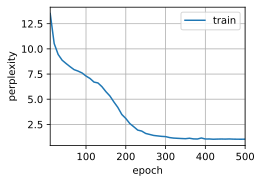

In [16]:
# 现在我们可以训练循环神经网络模型
# 设置迭代周期数和学习率
num_epochs, lr = 500, 1
# 调用训练函数进行模型训练，使用训练数据迭代器、词汇表、学习率、迭代周期数和设备信息作为输入
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

困惑度 1.3, 89288.9 标记/秒 cuda:0
time travellerit s against reason said filbywhat rather a large 
travellerit s against reason said filbywhat rather a large 


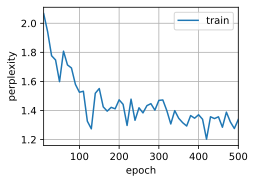

In [17]:
# 最后，让我们检查一下使用随即抽样方法的结果
# 调用训练函数进行模型训练，使用训练数据迭代器、词汇表、学习率、迭代周期数、设备信息和随机抽样标志位作为输入
# 设置 use_random_iter 参数为 True，表示使用随机抽样方法进行训练
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(), use_random_iter=True) 